# Answers to questions
What is the average human life expectancy in the world?<br /> 
How does this differ between low-, medium, and high-income countries? <br />
What characteristics of countries are predictors for differences in life expectancies? <br />
What characteristics are predictors for changes in life expectancy in a country over time?

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data_raw = pd.read_csv('data/processed/merged_data.csv')
# rename columns for convenience
data_raw.rename(index=str, columns={'Life expectancy at birth (years)  Both sexes': 'LE_both'}, inplace=True)
data_raw.rename(index=str, columns={'Life expectancy at birth (years)  Male': 'LE_male'}, inplace=True)
data_raw.rename(index=str, columns={'Life expectancy at birth (years)  Female': 'LE_female'}, inplace=True)
data_raw.rename(columns={data_raw.columns[6]: 'GDP'}, inplace=True)
# Current health expenditure (CHE) per capita in US$
data_raw.rename(columns={data_raw.columns[7]: 'Health_expenditure'}, inplace=True)
# Research and development expenditure
data_raw.rename(columns={data_raw.columns[8]: 'RnD'}, inplace=True)
#
# basic cleansing
#
# checking and preparing data types of raw data
# as we have categorial data in Income level, we must set the correct data type
data_raw['Income Level'] = data_raw['Income Level'].astype('category')
# assign value to each category value - Index(['H', 'L', 'LM', 'UM', 'Unknown'], dtype='object')
data_raw['Income Level'].cat.categories = [4,1,2,3,0]
data_raw['Income Level'].astype(float)
#data_raw['RnD'].astype(float)

# South Sudan didn't exist before 2011
data_raw.drop(data_raw.loc[(data_raw['Country'] == 'South Sudan') & (data_raw['Year'] <= 2010)].index, inplace=True)

#
# setting income level correctly if we have GDP values
#
data_raw['Income Level'] = data_raw['Income Level'].replace(np.NaN, 'Unknown', inplace=False, regex=True)

incomplete_data = (data_raw[data_raw['Income Level'] == 'Unknown'])
incomplete_data.loc[:, 'Income Level'] = incomplete_data['Income Level'].mask(incomplete_data.GDP < 995, 'L')
incomplete_data.loc[:, 'Income Level'] = incomplete_data['Income Level'].mask(incomplete_data.GDP > 995, 'LM')

# we simply drop the remaining incomplete lines
data_raw['Income Level'] = data_raw['Income Level'].replace('Unknown', np.NaN, inplace=False, regex=True)
data_raw.dropna(subset=['Income Level'], inplace=True)

# finally copy data_raw to data which represents the cleansed data
data = data_raw.copy()

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
5       1.0
6       1.0
7       1.0
8       1.0
9       1.0
10      1.0
11      1.0
12      1.0
13      1.0
14      1.0
15      1.0
16      1.0
17      3.0
18      3.0
19      3.0
20      3.0
21      3.0
22      2.0
23      3.0
24      3.0
25      2.0
26      2.0
27      2.0
28      2.0
29      2.0
       ... 
3081    2.0
3082    2.0
3083    2.0
3084    1.0
3085    1.0
3086    1.0
3087    1.0
3088    1.0
3089    1.0
3090    1.0
3091    1.0
3092    1.0
3093    1.0
3094    1.0
3095    1.0
3096    1.0
3097    1.0
3098    1.0
3099    1.0
3100    1.0
3101    1.0
3102    1.0
3103    1.0
3104    1.0
3105    1.0
3106    1.0
3107    1.0
3108    1.0
3109    1.0
3110    1.0
Name: Income Level, Length: 3083, dtype: float64


/usr/share/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Side step checking correlation between GDP and income level 
show strong correlation between GDP and GNI before correction of Income Level "Unknown" based on GDP data
greater than 0.7 means strong positive correlation

In [35]:
correlations = data_raw.corr()
print(correlations)

                        Year   LE_both   LE_male  LE_female  Income Level  \
Year                1.000000  0.187285  0.195123   0.176401      0.168288   
LE_both             0.187285  1.000000  0.992070   0.993657      0.763546   
LE_male             0.195123  0.992070  1.000000   0.972337      0.758186   
LE_female           0.176401  0.993657  0.972337   1.000000      0.758519   
Income Level        0.168288  0.763546  0.758186   0.758519      1.000000   
GDP                 0.146966  0.587497  0.607945   0.560007      0.712903   
Health_expenditure  0.147828  0.544997  0.559859   0.519897      0.623381   

                         GDP  Health_expenditure  
Year                0.146966            0.147828  
LE_both             0.587497            0.544997  
LE_male             0.607945            0.559859  
LE_female           0.560007            0.519897  
Income Level        0.712903            0.623381  
GDP                 1.000000            0.915431  
Health_expenditure  0.9154

### 1. What is the average human life expectancy in the world?

In [31]:
print("The average life expectancy for both sexes is: {0}".format(data['LE_both'].mean()))
print("The average life expectancy for women is : {0}".format(data['LE_female'].mean()))
print("The average life expectancy for men is : {0}".format(data['LE_male'].mean()))

The average life expectancy for both sexes is: 69.20586319218235
The average life expectancy for women is : 71.57491856677521
The average life expectancy for men is : 66.86951140065143


### 2. How does this differ between low-, medium, and high-income countries? 

In [47]:
datagrouped = data.groupby(['Income Level'])
datagrouped['LE_both', 'LE_female', 'LE_male'].mean().sort_values(['LE_both'],ascending=False)

,LE_both,LE_female,LE_male
Income Level,,,
H,78.480728,80.987466,75.962803
UM,72.419625,75.444300,69.486147
LM,68.115169,70.597200,65.696616
L,58.698972,60.228278,57.158226


### 3. What characteristics of countries are predictors for differences in life expectancies?

In [33]:
from sklearn.decomposition import PCA
print(data.head)

#print(data.columns)
'''
pca = PCA(n_components=5)
pca.fit(data)
#pca.components_
columns = ['pca_%i' % i for i in range(5)]
df_pca = DataFrame(pca.transform(data), columns=columns, index=data.index)
df_pca.head()
'''

<bound method NDFrame.head of           Country  Year  LE_both  LE_male  LE_female Income Level  \
0     Afghanistan  2016     62.7     61.0       64.5            L   
1     Afghanistan  2015     63.2     61.8       64.7            L   
2     Afghanistan  2014     63.0     61.7       64.4            L   
3     Afghanistan  2013     62.7     61.5       64.1            L   
4     Afghanistan  2012     62.2     60.9       63.6            L   
5     Afghanistan  2011     61.7     60.5       63.1            L   
6     Afghanistan  2010     61.2     59.9       62.5            L   
7     Afghanistan  2009     60.7     59.5       62.1            L   
8     Afghanistan  2008     60.2     59.0       61.6            L   
9     Afghanistan  2007     59.6     58.4       61.0            L   
10    Afghanistan  2006     59.2     58.0       60.5            L   
11    Afghanistan  2005     58.9     57.8       60.1            L   
12    Afghanistan  2004     58.4     57.4       59.6            L   
13  

"\npca = PCA(n_components=5)\npca.fit(data)\n#pca.components_\ncolumns = ['pca_%i' % i for i in range(5)]\ndf_pca = DataFrame(pca.transform(data), columns=columns, index=data.index)\ndf_pca.head()\n"

                        Year   LE_both   LE_male  LE_female  Income Level  \
Year                1.000000  0.187285  0.195123   0.176401      0.168288   
LE_both             0.187285  1.000000  0.992070   0.993657      0.763546   
LE_male             0.195123  0.992070  1.000000   0.972337      0.758186   
LE_female           0.176401  0.993657  0.972337   1.000000      0.758519   
Income Level        0.168288  0.763546  0.758186   0.758519      1.000000   
GDP                 0.146966  0.587497  0.607945   0.560007      0.712903   
Health_expenditure  0.147828  0.544997  0.559859   0.519897      0.623381   

                         GDP  Health_expenditure  
Year                0.146966            0.147828  
LE_both             0.587497            0.544997  
LE_male             0.607945            0.559859  
LE_female           0.560007            0.519897  
Income Level        0.712903            0.623381  
GDP                 1.000000            0.915431  
Health_expenditure  0.9154

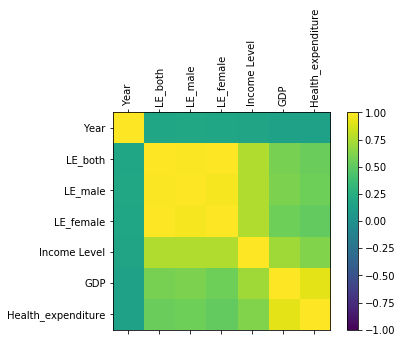

In [38]:
correlations = data.corr()
print(correlations)
# plot correlation matrix
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ax.xaxis.set_tick_params(rotation=90)
ax.set_xticklabels(data.columns)
ax.set_yticklabels(data.columns)
plt.show()

As we can see this is not satisfactoring result, there is no strong correlation between GDP and life expectancy at birth. So let's look at a scatter plot and check if there is at least some linear relation between these variables.

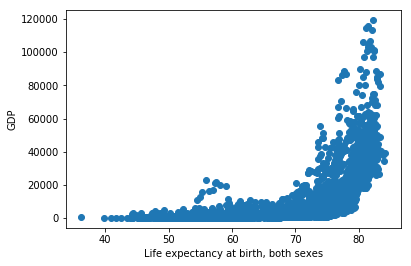

In [35]:
from pandas.plotting import scatter_matrix
#scatter_matrix(data)
#plt.show()
# show simple scatter plot
plt.ylabel('GDP')
plt.xlabel('Life expectancy at birth, both sexes')
plt.scatter(data["LE_both"], data["GDP"])

Next, we'll look at the correlation between 70 and older, maybe we can get better results.

                        Year   LE_both   LE_male  LE_female       GDP  \
Year                1.000000  0.176792  0.169786   0.170633  0.132430   
LE_both             0.176792  1.000000  0.962756   0.958128  0.731436   
LE_male             0.169786  0.962756  1.000000   0.846477  0.728348   
LE_female           0.170633  0.958128  0.846477   1.000000  0.679895   
GDP                 0.132430  0.731436  0.728348   0.679895  1.000000   
Health_expenditure  0.151750  0.747082  0.716340   0.713568  0.899209   

                    Health_expenditure  
Year                          0.151750  
LE_both                       0.747082  
LE_male                       0.716340  
LE_female                     0.713568  
GDP                           0.899209  
Health_expenditure            1.000000  


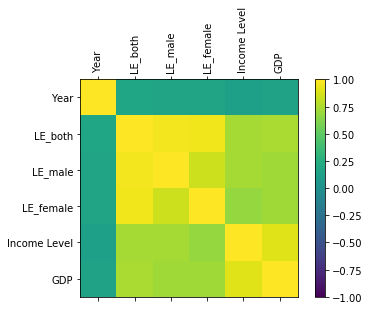

In [36]:
data_elderly = data[data.LE_both > 70]
correlations_elderly = data_elderly.corr()
print(correlations_elderly)
# plot correlation matrix
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations_elderly, vmin=-1, vmax=1)
fig.colorbar(cax)
ax.xaxis.set_tick_params(rotation=90)
ax.set_xticklabels(data.columns)
ax.set_yticklabels(data.columns)
plt.show()